<a href="https://colab.research.google.com/github/jtvon/Module-7-Assignments/blob/main/MilestoneTwo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Milestone Two

**Data Preparation and Model Exploration**
**Due:** Midnight on November 16th with usual 2-hour grace period — **worth 100 points**

**Note: No late assignments accepted, we need the time to grade them!**

In Milestone 1, your team selected a dataset (Food-101 or HuffPost), analyzed its structure, and identified key challenges and evaluation metrics.
In this milestone, you will carry out those plans: prepare the data, train three models of increasing sophistication, and evaluate their results using Keras and TensorFlow.
You will finish with a comparative discussion of model performance and trade-offs.


### Submission Guidelines

* Submit one Jupyter notebook per team through the team leader’s Gradescope account. **Include all team members names at the top of the notebook.**
* Include all code, plots, and answers inline below.
* Ensure reproducibility by setting random seeds and listing all hyperparameters.
* Document any AI tools used, as required by the CDS policy.


## Problem 1 – Data Preparation and Splits (20 pts)

### Goals

Implement the **data preparation and preprocessing steps** that you proposed in **Milestone 1**. You’ll clean, normalize, and split your data so that it’s ready for modeling and reproducible fine-tuning.

### Steps to Follow

1. **Load your chosen dataset**

   * Use `datasets.load_dataset()` from **Hugging Face** to load **Food-101** or **HuffPost**.
   * Display basic information (e.g., number of samples, feature names, example entries).

2. **Apply cleaning and normalization**

   * **Images:**

     * Ensure all images are in RGB format.
     * Resize or crop to a consistent shape (e.g., `224 × 224`).
     * Drop or fix any corrupted files.
   * **Text:**

     * Concatenate headline + summary (for HuffPost).
     * Strip whitespace, convert to lowercase if appropriate, and remove empty samples.
     * Optionally remove duplicates or extremely short entries.

3. **Standardize or tokenize the inputs**

   * **Images:**

     * Normalize pixel values (e.g., divide by 255.0).
     * Define a minimal augmentation pipeline (e.g., random flip, crop, or rotation).
   * **Text:**

     * Create a tokenizer or `TextVectorization` layer.
     * Set a target `max_length` based on your analysis from Milestone 1 (e.g., 95th percentile).
     * Apply padding/truncation and build tensors for input + labels.

4. **Handle dataset-specific challenges**

   * If you identified **class imbalance**, compute label counts and, if needed, create a dictionary of `class_weights`.
   * If you noted **length or size variance**, verify that your truncation or resizing works as intended.
   * If you planned **noise filtering**, include the cleaning step and briefly explain your criteria (e.g., remove items with missing text or unreadable images).

5. **Create reproducible splits**

   * Split your cleaned dataset into **train**, **validation**, and **test** subsets (e.g., 80 / 10 / 10).
   * Use a fixed random seed for reproducibility (`random_seed = 42`).
   * Use **stratified splits**  (e.g., with `train_test_split` and `stratify = labels`).
   * Display the size of each subset.

6. **Document your pipeline**

   * Summarize your preprocessing steps clearly in Markdown or code comments.
   * Save or display a few representative examples after preprocessing to confirm the transformations are correct.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, math, random, hashlib
from collections import Counter
import numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
import time
from datasets import load_dataset, ClassLabel, DatasetDict

from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Sequential, callbacks, regularizers, initializers
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import  confusion_matrix

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.layers import LayerNormalization, MaxPooling2D,Dropout,GlobalAveragePooling2D,Dense
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,GlobalMaxPooling1D, Flatten, TextVectorization
from sklearn.model_selection import StratifiedShuffleSplit

from datetime import datetime

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

results = {}
parameter_settings = {}


In [ ]:
# Load HuffPost dataset
URL = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff_all = load_dataset("json", data_files=URL, split="train")

# Preprocess dataset: combine headline and short_description into text
def make_text(ex):
    h = (ex.get("headline") or "").strip()
    s = (ex.get("short_description") or "").strip()
    return {"text": (h + " [SEP] " + s).strip()}

# Apply preprocessing
huff_all = huff_all.map(make_text)
huff_all = huff_all.rename_column("category","label_str")

# Encode labels if not already encoded
if "label" not in huff_all.column_names or not isinstance(huff_all.features["label_str"], ClassLabel):
    huff_all = huff_all.class_encode_column("label_str")
    huff_all = huff_all.rename_column("label_str","label")

# Print dataset size and number of labels
label_names = huff_all.features["label"].names
print(len(huff_all), len(label_names))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


200853 41


In [ ]:
huff_all

Dataset({
    features: ['label', 'headline', 'authors', 'link', 'short_description', 'date', 'text'],
    num_rows: 200853
})

9.614977973568282


,label_id,count,label_name
4,24,32739,POLITICS
31,37,17827,WELLNESS
1,10,16058,ENTERTAINMENT
12,34,9887,TRAVEL
34,30,9649,STYLE & BEAUTY
32,22,8677,PARENTING
25,16,6694,HEALTHY LIVING
9,25,6314,QUEER VOICES
37,13,6226,FOOD & DRINK
11,3,5937,BUSINESS


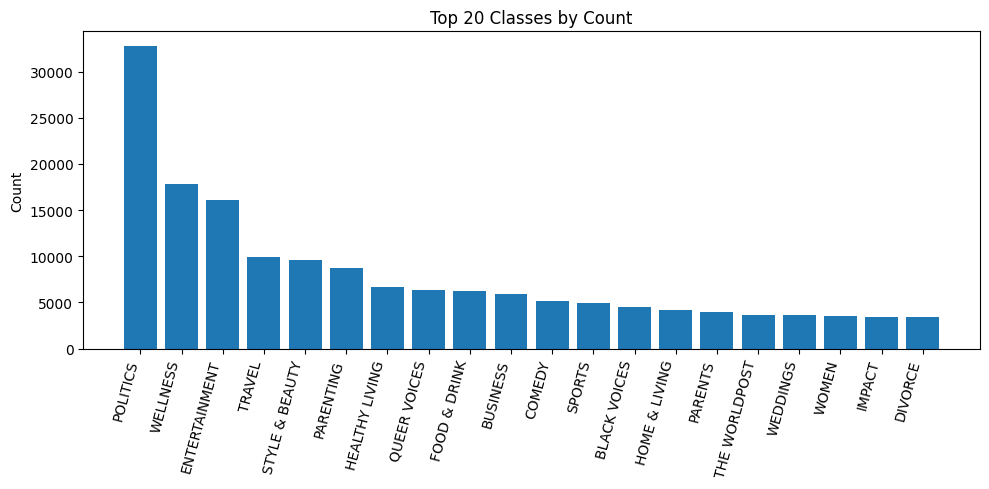

In [ ]:
# Count labels in the dataset
counts = Counter(huff_all["label"])
count_df = pd.DataFrame({"label_id": list(counts.keys()), "count": list(counts.values())}).sort_values("count", ascending=False)
count_df["label_name"] = count_df["label_id"].apply(lambda i: label_names[i])
imbalance_ratio = count_df["count"].max() / count_df["count"].median()
print(imbalance_ratio)

# Display the label counts
display(count_df.head(10))
plt.figure(figsize=(10,5))
plt.bar(count_df["label_name"][:20], count_df["count"][:20])
plt.xticks(rotation=75, ha="right")
plt.ylabel("Count")
plt.title("Top 20 Classes by Count")
plt.tight_layout()
plt.show()

{'percentile_50': 29, 'percentile_75': 36, 'percentile_90': 50, 'percentile_95': 57, 'percentile_99': 68}


Min length: 1, Max length: 246, Mean length: 30.26685187674568, Std length: 14.04689916977026


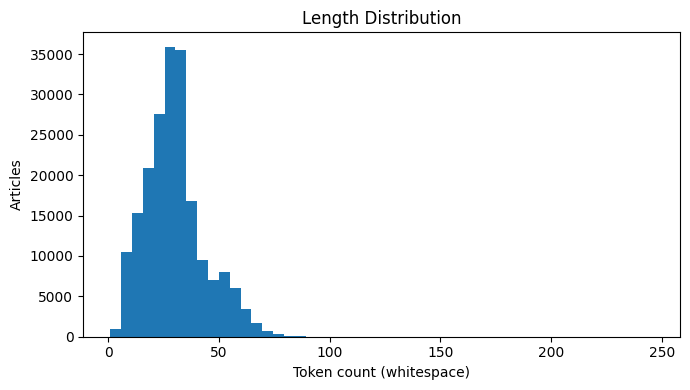

In [ ]:
# Sentence length analysis
def rough_len(s):
    return len((s or "").split())

# Calculate lengths and display statistics
lens = np.array([rough_len(t) for t in huff_all["text"]])
pcts = [50,75,90,95,99]
print({f"percentile_{p}":int(np.percentile(lens,p)) for p in pcts})
print('\n')
print(f"Min length: {int(lens.min())}, Max length: {int(lens.max())}, Mean length: {float(lens.mean())}, Std length: {float(lens.std())}")
plt.figure(figsize=(7,4))
plt.hist(lens, bins=50)
plt.xlabel("Token count (whitespace)")
plt.ylabel("Articles")
plt.title("Length Distribution")
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the truncate rate
def trunc_rate(L):
    return float((lens > L).sum())/len(lens)
candidates = [64,128,192,256,320,384,448,512]
tr = pd.DataFrame({"max_length": candidates, "truncation_rate": [trunc_rate(L) for L in candidates]})
display(tr)

,max_length,truncation_rate
0,64,0.016027
1,128,0.000831
2,192,0.000060
3,256,0.000000
4,320,0.000000
5,384,0.000000
6,448,0.000000
7,512,0.000000


In [ ]:
# Check for duplicate articles
def md5(s):
    return hashlib.md5((s or "").encode("utf-8")).hexdigest()
hashes = [md5(t) for t in huff_all["text"]]
dupe_counts = pd.Series(hashes).value_counts()
num_groups = int((dupe_counts > 1).sum())
print(num_groups)
if num_groups:
    dup_hash = dupe_counts[dupe_counts > 1].index[0]
    idxs = [i for i,h in enumerate(hashes) if h == dup_hash][:3]
    for i in idxs:
        ex = huff_all[i]
        print(ex["text"][:200])
        print(label_names[ex['label']])


    # Remove dupes from the dataset
    unique_hashes = set()
    keep_idxs = []
    for i,h in enumerate(hashes):
        if h not in unique_hashes:
            unique_hashes.add(h)
            keep_idxs.append(i)
    huff_all = huff_all.select(keep_idxs)
    print()
    print(f"Removed dupes, new dataset size: {len(huff_all)}")

209
Watch The Top 9 YouTube Videos Of The Week [SEP] If you're looking to see the most popular YouTube videos of the week, look no further. Once again, we're bringing you the
TECH
Watch The Top 9 YouTube Videos Of The Week [SEP] If you're looking to see the most popular YouTube videos of the week, look no further. Once again, we're bringing you the
TECH
Watch The Top 9 YouTube Videos Of The Week [SEP] If you're looking to see the most popular YouTube videos of the week, look no further. Once again, we're bringing you the
TECH

Removed dupes, new dataset size: 200365


In [ ]:
# print examples of articles
k, seed = 5, 17
rng = random.Random(seed)
idxs = rng.sample(range(len(huff_all)), k)
for i in idxs:
    ex = huff_all[i]
    print("[" + label_names[ex["label"]] + "] " + ex["text"][:240])
    print()

[WELLNESS] Experimental Leukemia Drug Effective In Most Patients Who Don't Benefit From Other Treatments: Trial [SEP] AbbVie is developing the once-daily pill in partnership with Roche Holding AG. In the ongoing study, 72 percent of patients

[ENTERTAINMENT] This Is What Johnny Depp Looks Like In 'Into The Woods' [SEP]

[POLITICS] Jeb Bush Prodded By Immigration Protesters, Touts Support For Dreamers [SEP] He says he'll stick to his stance "irrespective of what the political ramifications of that are."

[POLITICS] Lone House Democratic Co-Sponsor Of Trafficking Bill Jumps Ship Over Anti-Abortion Provision [SEP]

[QUEER VOICES] Ireland Legalizes Same-Sex Marriage [SEP] The Republic of Ireland's same-sex marriage bill has been signed into law by the Presidential Commission. It became the first



In [ ]:
# Split dataset into train, validation, and test sets
tmp  = huff_all.train_test_split(test_size=0.20, seed=42, stratify_by_column="label")
train_val = tmp["train"].train_test_split(test_size=0.1765, seed=42, stratify_by_column="label")
ds = DatasetDict(train=train_val["train"], val=train_val["test"], test=tmp["test"])
print({k: len(v) for k,v in ds.items()})

{'train': 132000, 'val': 28292, 'test': 40073}


In [ ]:
print(tmp["train"][0])

{'label': 15, 'headline': 'California Beachgoers To Tackle Surfer Gang Bullies With Integration Challenge On MLK Day', 'authors': 'Mary Papenfuss', 'link': 'https://www.huffingtonpost.com/entry/infamous-california-surfer-bullies-face-challenge-on-mlk-day_us_5879ca87e4b09281d0eb28da', 'short_description': 'Actor Christopher Taloa and other ocean lovers will go to the beach the Lunada Bay Boys claim as their territory.', 'date': datetime.datetime(2017, 1, 14, 0, 0), 'text': 'California Beachgoers To Tackle Surfer Gang Bullies With Integration Challenge On MLK Day [SEP] Actor Christopher Taloa and other ocean lovers will go to the beach the Lunada Bay Boys claim as their territory.'}


In [ ]:
# Set max_length based on truncation analysis
MAX_LENGTH = 65  # Max Text Length
MAX_TOKENS = 100000  # Vocabulary size

# Create TextVectorization layer
text_vectorizer = TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode='int',
    output_sequence_length=MAX_LENGTH,
    standardize='lower_and_strip_punctuation',
    split='whitespace'
)

# Adapt vectorizer to training data only (avoid data leakage)
text_vectorizer.adapt(ds["train"]["text"])

print(f"Vocabulary size: {len(text_vectorizer.get_vocabulary())}")
print(f"Max sequence length: {MAX_LENGTH}")

# Test the vectorizer on a sample
sample_text = ds["train"]["text"][0]
vectorized = text_vectorizer([sample_text])
print(f"\nOriginal text: {sample_text[:200]}...")
print(f"Vectorized shape: {vectorized.shape}")
print(f"First 20 tokens: {vectorized[0][:20].numpy()}")

Vocabulary size: 99347
Max sequence length: 65

Original text: How To Overcome Self-Doubt [SEP] If you've run out of steam, maybe it's your body trying to tell you something. When you are feeling overwhelmed, instead of giving up, just take a break. Don't abandon...
Vectorized shape: (1, 65)
First 20 tokens: [  36    4 3103 8927    3   56  487  488   45    6 8913  583   32   20
  346  414    4  322   13  168]


In [ ]:
# Convert datasets to TensorFlow format for baseline/custom models
def prepare_tf_dataset(split_name, batch_size=32, shuffle=False, bert=False):

    # Convert HuggingFace columns to lists (TF can't handle HF Column objects)
    texts = list(ds[split_name]["text"])
    labels = list(ds[split_name]["label"])

    # Create tf.data.Dataset
    tf_ds = tf.data.Dataset.from_tensor_slices((texts, labels))

    # Shuffle training data only
    if shuffle:
        tf_ds = tf_ds.shuffle(buffer_size=10000, seed=42)

    # Batch first, then apply vectorization (vectorizer expects batches)
    tf_ds = tf_ds.batch(batch_size)

    # Apply text vectorization and one-hot encoding
    def vectorize_and_encode(text_batch, label_batch):
        if bert:
            vectorized_text = text_batch
        else:
            vectorized_text = text_vectorizer(text_batch)
        one_hot_labels = tf.one_hot(label_batch, depth=len(label_names))
        return vectorized_text, one_hot_labels

    tf_ds = tf_ds.map(vectorize_and_encode, num_parallel_calls=tf.data.AUTOTUNE)
    tf_ds = tf_ds.prefetch(tf.data.AUTOTUNE)

    return tf_ds

# Create TensorFlow datasets for baseline and custom models
train_ds_tf = prepare_tf_dataset("train", batch_size=64, shuffle=False, bert=False)
val_ds_tf = prepare_tf_dataset("val", batch_size=64, shuffle=False, bert=False)
test_ds_tf = prepare_tf_dataset("test", batch_size=64, shuffle=False, bert=False)

print("TensorFlow datasets created:")
print(f"  Train batches: {tf.data.experimental.cardinality(train_ds_tf).numpy()}")
print(f"  Val batches: {tf.data.experimental.cardinality(val_ds_tf).numpy()}")
print(f"  Test batches: {tf.data.experimental.cardinality(test_ds_tf).numpy()}")

# Verify batch shapes
for text_batch, label_batch in train_ds_tf.take(1):
    print(f"\nBatch shapes:")
    print(f"  Text (vectorized): {text_batch.shape}")
    print(f"  Labels (one-hot): {label_batch.shape}")

TensorFlow datasets created:
  Train batches: 2063
  Val batches: 443
  Test batches: 627

Batch shapes:
  Text (vectorized): (64, 65)
  Labels (one-hot): (64, 41)


In [ ]:
# Class imbalance handling
def get_class_weights(dataset_split):

    # Extract labels from the dataset and grab unique classes
    labels = dataset_split["label"]
    classes = np.unique(labels)

    # Compute balanced class weights
    weights = compute_class_weight('balanced', classes=classes, y=labels)

    # Create dictionary mapping class index to weight
    class_weight_dict = {i: weight for i, weight in enumerate(weights)}

    return class_weight_dict

# Compute class weights from training data
class_weights = get_class_weights(ds["train"])

# Display statistics
print(f"Number of classes: {len(class_weights)}")
print(f"Weight range: {min(class_weights.values()):.3f} to {max(class_weights.values()):.3f}")
print(f"\nTop 5 highest weights (underrepresented classes):")

sorted_weights = sorted(class_weights.items(), key=lambda x: x[1], reverse=True)[:5]
for class_idx, weight in sorted_weights:
    label = label_names[class_idx]
    count = counts[class_idx]
    print(f"  Class {class_idx} ({label:20s}): weight={weight:.3f}, count={count}")

print(f"\nTop 5 lowest weights (overrepresented classes):")
sorted_weights = sorted(class_weights.items(), key=lambda x: x[1])[:5]
for class_idx, weight in sorted_weights:
    label = label_names[class_idx]
    count = counts[class_idx]
    print(f"  Class {class_idx} ({label:20s}): weight={weight:.3f}, count={count}")

Number of classes: 41
Weight range: 0.149 to 4.871

Top 5 highest weights (underrepresented classes):
  Class 9 (EDUCATION           ): weight=4.871, count=1004
  Class 7 (CULTURE & ARTS      ): weight=4.749, count=1030
  Class 19 (LATINO VOICES       ): weight=4.327, count=1129
  Class 4 (COLLEGE             ): weight=4.276, count=1144
  Class 11 (ENVIRONMENT         ): weight=3.696, count=1323

Top 5 lowest weights (overrepresented classes):
  Class 24 (POLITICS            ): weight=0.149, count=32739
  Class 37 (WELLNESS            ): weight=0.274, count=17827
  Class 10 (ENTERTAINMENT       ): weight=0.304, count=16058
  Class 34 (TRAVEL              ): weight=0.494, count=9887
  Class 30 (STYLE & BEAUTY      ): weight=0.514, count=9649


### Graded Questions (5 pts each)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible.

1. **Data Loading and Cleaning:**
   Describe how you loaded your dataset and the key cleaning steps you implemented (e.g., handling missing data, normalizing formats, or removing duplicates).



================================================

**Data Loading**
- Dataset loaded using HuggingFace's `datasets.load_dataset()` using URL containing json formatted data
- Features included ['category', 'headline', 'authors', 'link', 'short_description', 'date', 'text']

**Text Combination and Cleaning**
- Combined `headline` and `short_description` with `[SEP]` separator token. The purpose of the separator is to help models distinguish between headline and short_description
- Stripped whitespace from both fields before concatenating
- Empty/Null values were converted to empty strings

**Duplicate Removal and Text Length Analysis**
- MD5 hashes were generated for each text to identify duplicates, 209 were found and removed from the dataset
- Class Distribution analysis depicted severe class imbalance in the label feature, the most common being `Politics` at 32739 records and `Education` being the least common with 1004 records
- Text Length analysis was done to showcase the distribution, analysis discovered that 50% of text lengths were 29 tokens or less, the 95th percentile was 57 tokens
    
=================================================

2. **Preprocessing and Standardization:**
   Summarize your preprocessing pipeline. Include any normalization, tokenization, resizing, or augmentation steps, and explain why each was necessary for your dataset.
  

=================================================

**Label Encoding**
   - Converted categorical labels (41 news categories) to integer indices using HuggingFace's `class_encode_column`
   - Maintained label names for interpretability

**Length Analysis and Truncation Strategy**
   - Analyzed text length distribution (mean: ~29 tokens, 95th percentile: 32 tokens)
   - Calculated truncation rates at various max_length thresholds (64, 128, 192, 256, etc.)
   - Selected `max_length=65` to capture ~99%+ of text while balancing efficiency

**Tokenization**
   - Created Keras `TextVectorization` layer with:
     - Vocabulary size: 100,000 tokens
     - Output sequence length: 65 tokens
     - Standardization: lowercase + strip punctuation
     - Whitespace-based splitting
   - Adapted vectorizer on training data only (avoiding data leakage)

**TensorFlow Dataset Pipeline Creation**
   - Converted HuggingFace datasets to `tf.data.Dataset` format
   - Applied shuffling to training data (buffer size: 10,000, seed: 42)
   - Batched data (batch size: 64)
   - Applied text vectorization within the pipeline
   - One-hot encoded labels (41 classes) for categorical crossentropy loss
   - Added prefetching for performance optimization

**Class Imbalance Handling**
   - Computed class weights using sklearn's `compute_class_weight` with 'balanced' strategy
   - Weights range from 0.24 to 12.96 across 41 classes
   - Will be applied during model training to address 12.5:1 imbalance ratio

=================================================

3. **Train/Validation/Test Splits:**
   Explain how you divided your data into subsets, including the split ratios, random seed, and any stratification or leakage checks you used to verify correctness.

=================================================

**Training/Validation/Testing Splits**
   - Split data into 65% train / 15% validation / 20% test
   - Stratified Sampling was used to maintain class weighting across splits
   - Set random seed (42) for reproducibility
   - Train: ~132,000, Val: ~28,292, Test: ~40,073

=================================================

4. **Class Distribution and Balance:**
   Report your label counts and describe any class imbalances you observed. If applicable, explain how you addressed them (e.g., weighting, oversampling, or data augmentation).

=================================================

**Class Imbalance Handling**
   - Computed class weights using sklearn's `compute_class_weight` with 'balanced' strategy
   - Weights range from 0.24 to 12.96 across 41 classes
   - Will be applied during model training to address 12.5:1 imbalance ratio

=================================================

## Problem 2 – Baseline Model (20 pts)

### Goal

Build and train a **simple, fully functional baseline model** to establish a reference level of performance for your dataset.
This baseline will help you evaluate whether later architectures and fine-tuning steps actually improve results.


### Steps to Follow

1. **Construct a baseline model**

   * **Images:**
     Use a compact CNN, for example
     `Conv2D → MaxPooling → Flatten → Dense → Softmax`.
   * **Text:**
     Use a small embedding-based classifier such as
     `Embedding → GlobalAveragePooling → Dense → Softmax`.
   * Keep the model small enough to train in minutes on Colab.

2. **Compile the model**

   * Optimizer: `Adam` or `AdamW`.
   * Loss: `categorical_crossentropy` (for multi-class).
   * Metrics: at least `accuracy`; add `F1` if appropriate.

3. **Train and validate**

   * Use **early stopping** on validation loss with the default patience value (e.g., 5 epochs).
   * Record number of epochs trained and total runtime.

4. **Visualize results**

   * Plot **training vs. validation accuracy and loss**.
   * Carefully observe: does the model underfit, overfit, or generalize reasonably?

5. **Report baseline performance**

   * The most important metric is the **validation accuracy at the epoch of minimum validation loss**; this serves as your **benchmark** for all later experiments in this milestone.
   * Evaluate on the **test set** and record final metrics.

In [ ]:
def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

In [ ]:
def train_and_test(
                   model,
                   train_dataset,
                   val_dataset,
                   test_dataset,
                   title         = "Learning Curves",
                   epochs        = 200,                   # Just needs to be bigger than early stopping point
                   optimizer     = "Adam",
                   lr_schedule   = 1e-3,                  # Adam defaults
                   clipnorm      = None,
                   batch_size    = 128, # Only used if datasets are (X,y) tuples
                   loss          = "categorical_crossentropy",
                   metrics       = ["accuracy"],
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False,
                   class_weight = None # Added class_weight parameter
                  ):

    print(f"\n{title}\n")

    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule, clipnorm=clipnorm)
    else:
        opt = optimizer

    # Compiling the model
    model.compile(optimizer = opt,
                  loss       = loss,
                  metrics   = metrics
                 )

    if use_early_stopping:
        early_stop = EarlyStopping(
            monitor              = 'val_loss',
            patience             = patience,
            min_delta            = min_delta,
            restore_best_weights = True,               # this will mean that the model which produced the smallest validation loss will be returned
            verbose              = verbose
        )
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=epochs,
                        callbacks=cbs,
                        verbose=verbose,
                        class_weight=class_weight
                        )

    # Plot training history
    plot_learning_curves(history, title=title)

    # Find epoch with minimum validation loss
    val_losses = history.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = history.history['val_accuracy'][min_val_epoch]

    # Evaluate on test data
    if isinstance(test_dataset, tf.data.Dataset):
        test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
    else:
        X_test, y_test = test_dataset
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    # Print out results
    print(f"\nFinal Training Loss:          {history.history['loss'][-1]:.4f}")
    print(f"Final Training Accuracy:        {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Loss:          {history.history['val_loss'][-1]:.4f}")
    print(f"Final Validation Accuracy:      {history.history['val_accuracy'][-1]:.4f}")
    print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
    print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Accuracy Gap: {abs(val_acc_at_min_loss - test_accuracy):.6f}")

    # Print confusion matrix of predictions
    # Refactored for tf.data.Dataset

    # Create a dataset for prediction that yields only inputs (discarding labels)
    test_ds_for_prediction = test_dataset.map(lambda inputs, labels: inputs)

    all_predictions = model.predict(test_ds_for_prediction)
    all_true_labels_one_hot = []

    for _, labels_batch in test_dataset:
        all_true_labels_one_hot.append(labels_batch.numpy())

    y_true_one_hot = np.concatenate(all_true_labels_one_hot, axis=0)

    y_pred_classes = np.argmax(all_predictions, axis=1)
    y_true_classes = np.argmax(y_true_one_hot, axis=1)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=False, cmap='Blues', fmt='g',
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Store accuracy in results
    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

    # Store all information about run in parameter_settings
    global parameter_settings
    entry = {
        "title": title,
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "epochs": int(epochs),
        "optimizer": optimizer,
        "lr_schedule": lr_schedule,
        "clipnorm": clipnorm,
        "loss": loss,
        "batch_size": batch_size,
        "use_early_stopping": use_early_stopping,
        "patience": patience,
        "min_delta": min_delta,
        "Final Training Loss" : history.history['loss'][-1],
        "Final Training Accuracy" : history.history['accuracy'][-1],
        "Final Val Loss" : history.history['val_loss'][-1],
        "Final Val Accuracy" : history.history['val_accuracy'][-1],
        "Min Val Loss" : min_val_loss,
        "Min Val Loss Epoch" : min_val_epoch,
        "Val Acc @ Min Loss" : val_acc_at_min_loss,
        "Test Loss" : test_loss,
        "Test Acc" : test_accuracy,
        "Val-Test Accuracy Gap:" : abs(val_acc_at_min_loss - test_accuracy)
    }
    parameter_settings.setdefault(title, []).append(entry)

    if return_history:
        return history

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-5,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

#  put in the callbacks list:

#    train_and_test(model, title="Learning Curves",callbacks=[reduce_lr])

In [ ]:
# Create an embedding matrix using GloVe embeddings
training_vocabulary = text_vectorizer.get_vocabulary()
training_vocabulary_size = len(training_vocabulary)
embedding_dimension = 300

# Create an empty embedding matrix
embedding_matrix = np.zeros((training_vocabulary_size, embedding_dimension))

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open(f'/content/drive/MyDrive/glove.6B/glove.6B.{embedding_dimension}d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except ValueError:
            # Skip lines that cause a ValueError (e.g., corrupted lines)
            print(f"Skipping line due to parsing error: {line[:50]}...") # Optional: print a message for skipped lines
            continue

print(f'Found {len(embeddings_index)} word vectors.')

# Fill the matrix with GloVe vectors if the word is in the vocabulary
for i, word in enumerate(training_vocabulary):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Skipping line due to parsing error: faceless -0.39856 -0.15699 0.056486 -0.12885 0.066...
Found 40069 word vectors.
Embedding matrix shape: (99347, 300)


In [ ]:
# Establish baseline frozen model
max_text_length = MAX_LENGTH          # Use the max length defined earlier

model_baseline = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    GlobalAveragePooling1D(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2()),
    Dense(len(label_names), activation='softmax')
])

model_baseline.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 65, 300)        │    29,804,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       154,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 41)             │        21,033 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,979,245 (114.36 MB)

 Trainable params: 29,979,245 (114.36 MB)

 Non-trainable params: 0 (0.00 B)


model_baseline (unfrozen)


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.


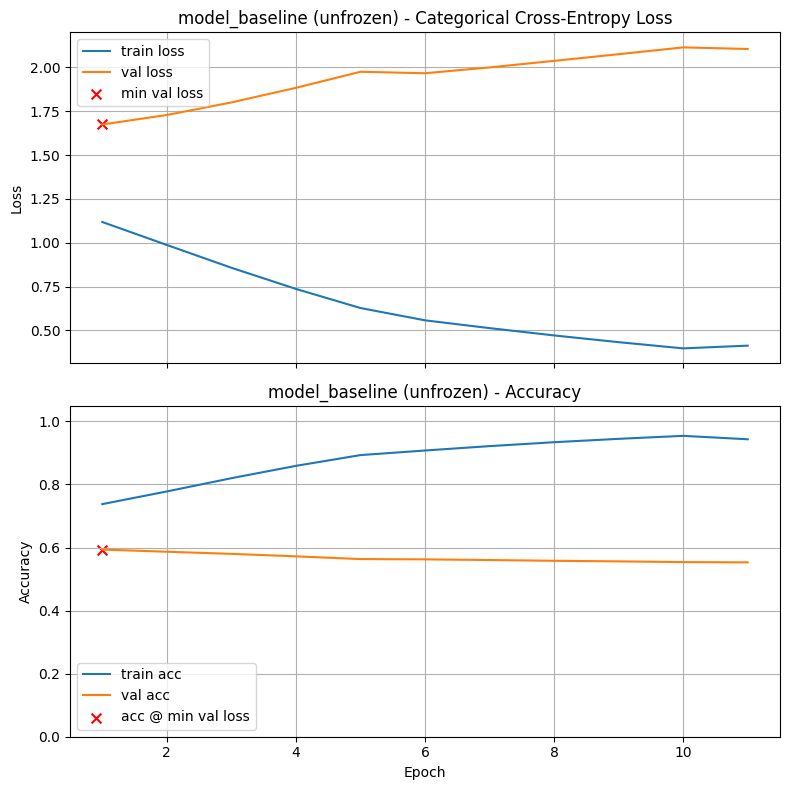


Execution Time: 00:01:15

Final Training Loss:          0.4133
Final Training Accuracy:        0.9433
Final Validation Loss:          2.1053
Final Validation Accuracy:      0.5529
Minimum Validation Loss:        1.6747 (Epoch 1)
Validation Accuracy @ Min Loss: 0.5935

Test Loss: 1.6727
Test Accuracy: 0.5930

Validation-Test Accuracy Gap: 0.000472
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Confusion Matrix:


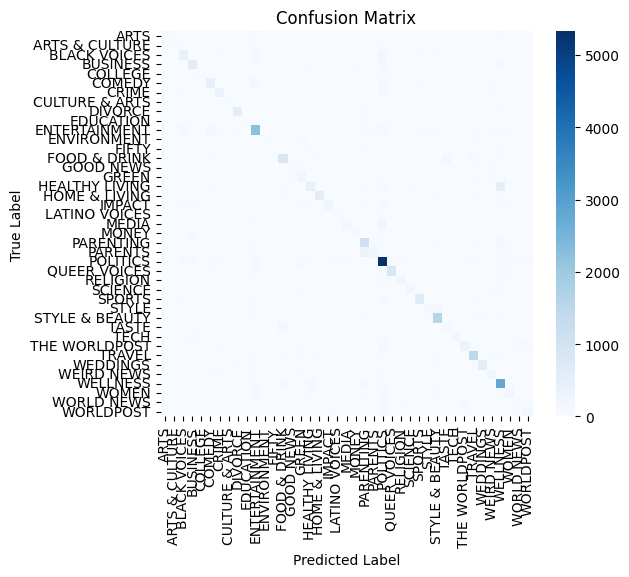

In [ ]:
train_and_test(model_baseline,
                train_ds_tf,
                val_ds_tf,
                test_ds_tf,
                lr_schedule=8e-4,
                title="model_baseline (unfrozen)",
                # class_weight=class_weights,
                callbacks=[reduce_lr])

### Graded Questions (5 pts each)

1. **Model Architecture:**
   Describe your baseline model and justify why this structure suits your dataset.

2.1. Baseline model included all the suggested modeling strategies in the instructions. The input layer was created with a max text length of 64. Next, an embedding layer was created with the input dimension corresponding to the max vocabulary size of 99,347, and the output dimension size of 300 corresponding to the glove6b pre-trainined embeddings. A Global average pooling layer and a 512 unit Dense layer with L2 regularization were added also. The final dense layer with the softmax funciton rounded out the baseline model.

The embedding layer was left trainable as it improved validation and test results dramatically. The addition of the 512 dense layer also improved the baseline model significantly, this is due to the dataset requiring a more complex model structure. The training and testing for this baseline initially didn't perform well, mainly because of the model simplicity. As a baseline, this model structure suits the dataset well because it leaves a lot to be improved upon. Additional Dense layers would allow complex relationships to be captured, while different activation functions could perform better.

2. **Training Behavior:**
   Summarize the model’s training and validation curves. What trends did you observe?

2.2. The models training curves suggest that it's able to capture the most important elements, although the speed at which the model gets to its optimal could be improved upon. Validation accuracy plateaus early on in training suggesting the baseline is still too simple so capture complex relationships. Validation loss exhibited strange behavior early on in training validating the claim that the baseline model isn't quite complex enough.



  3. **Baseline Metrics:**
   Report validation and test metrics. What does this performance tell you about dataset difficulty?

2.3. This dataset overall is very complex since there exists extreme class imbalance within the target variable. This alone can be the greatest issue when optimizing an ML model. The vast amount of data looks to require a much more powerful modeling solution, which means longer training times.



  4. **Reflection:**
   What are the main limitations of your baseline? Which specific improvements (depth, regularization, pretraining) would you try next?
  

2.4. Immediate improvements to the base line would be adding a batch normalization and dropout layer for better regularization and generalizability. The current baseline is leaning towards overfitting the data even with its poor performance. Adding a pretrained model will most likely improve the baseline significantly. Experimenting with layer size and depth could also be fruitful.



## Problem 3 – Custom (Original) Model (20 pts)

### Goal

Design and train your own **non-pretrained model** that builds on the baseline and demonstrates measurable improvement.
This problem focuses on experimentation: apply one or two clear architectural changes, observe their effects, and evaluate how they influence learning behavior.


### Steps to Follow

1. **Modify or extend your baseline architecture**

   * Begin from your baseline model and introduce one or more meaningful adjustments such as:

     * Adding **dropout** or **batch normalization** for regularization.
     * Increasing **depth** (extra convolutional or dense layers).
     * Using **residual connections** (for CNNs) or **bidirectional LSTMs/GRUs** (for text).
     * Trying alternative activations like `ReLU`, `LeakyReLU`, or `GELU`.
   * Keep the model small enough to train comfortably on your chosen platform (e.g., Colab)

2. **Observe what specific limitations you want to address**

   * Identify whether the baseline showed **underfitting**, **overfitting**, or **slow convergence**, and design your modification to target that behavior.
   * Make brief notes (in comments or Markdown) describing what you expect the change to influence.

3. **Train and evaluate under the same conditions**

   * Use the **same data splits**, **random seed**, and **metrics** as in Problem 2.
   * Apply **early stopping** on validation loss.
   * Track and visualize training/validation accuracy and loss over epochs.

4. **Compare outcomes to the baseline**

   * Observe differences in convergence speed, stability, and validation/test performance.
   * Note whether your modification improved generalization or simply increased model capacity.

## Dropout Testing

Want to address the overfitting exhibited with the baseline model, the performance on the validation sets were much better than on the test set.


model_custom w/ a 0.1 dropout set


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.


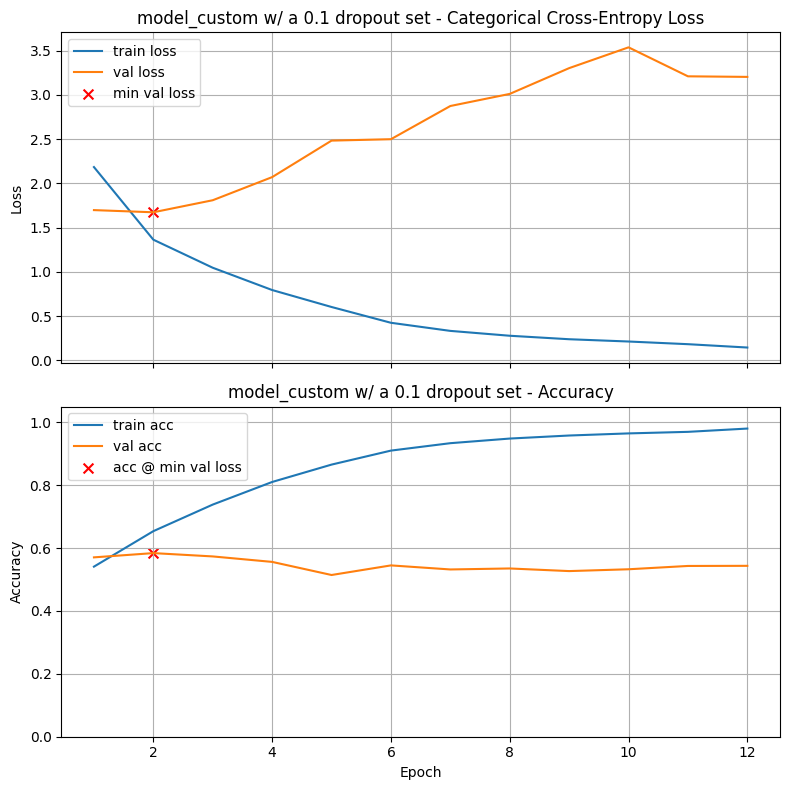


Execution Time: 00:01:24

Final Training Loss:          0.1449
Final Training Accuracy:        0.9799
Final Validation Loss:          3.2031
Final Validation Accuracy:      0.5434
Minimum Validation Loss:        1.6732 (Epoch 2)
Validation Accuracy @ Min Loss: 0.5839

Test Loss: 1.6641
Test Accuracy: 0.5858

Validation-Test Accuracy Gap: 0.001881
627/627 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Confusion Matrix:


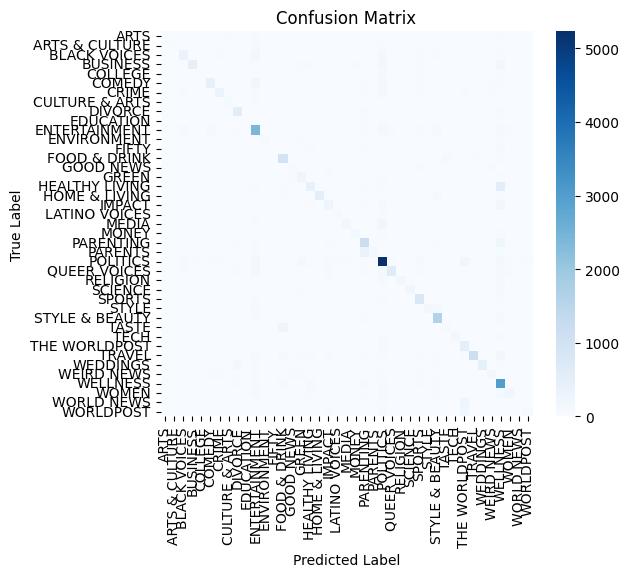


model_custom w/ a 0.2 dropout set


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.


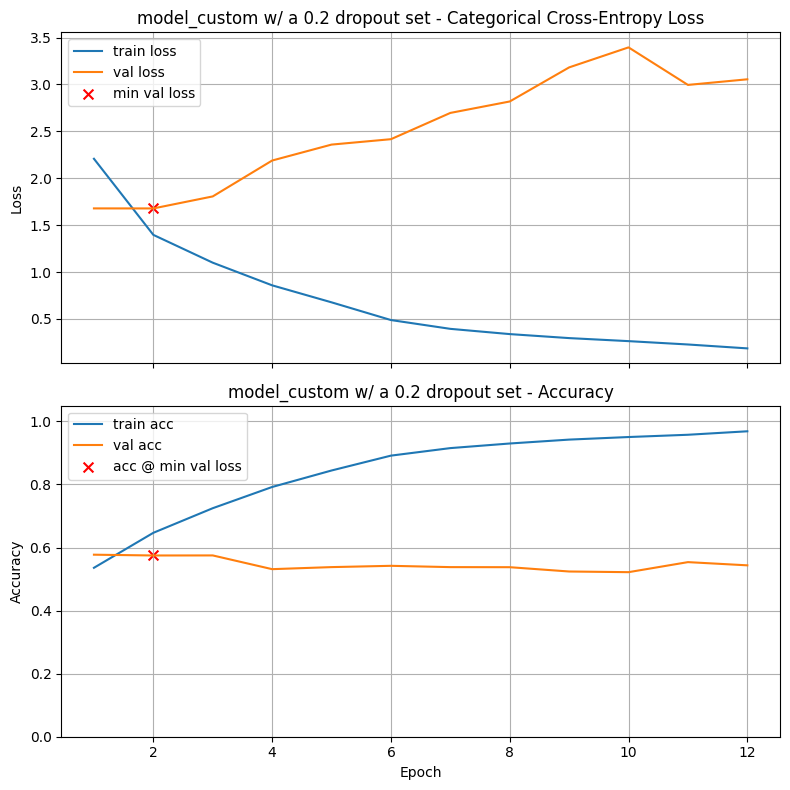


Execution Time: 00:01:22

Final Training Loss:          0.1857
Final Training Accuracy:        0.9686
Final Validation Loss:          3.0550
Final Validation Accuracy:      0.5435
Minimum Validation Loss:        1.6780 (Epoch 2)
Validation Accuracy @ Min Loss: 0.5748

Test Loss: 1.6699
Test Accuracy: 0.5767

Validation-Test Accuracy Gap: 0.001941
627/627 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Confusion Matrix:


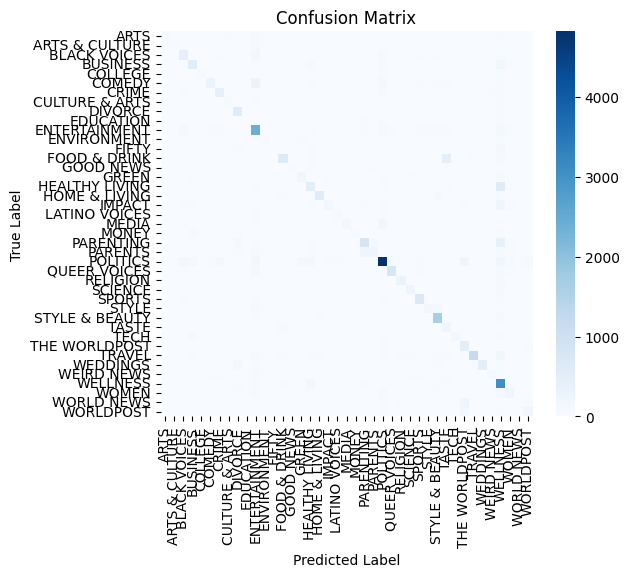


model_custom w/ a 0.3 dropout set


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.


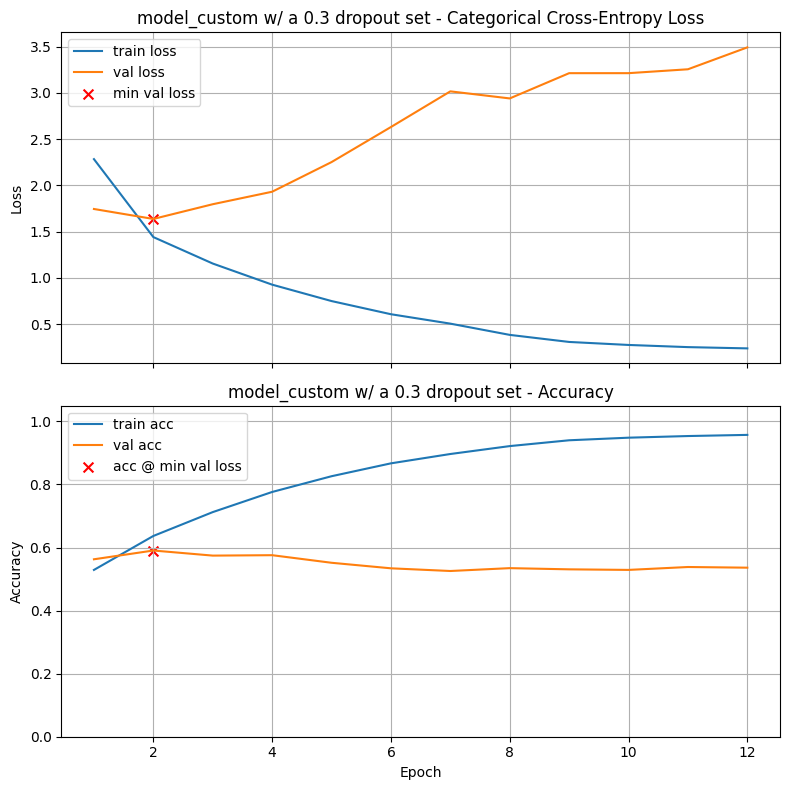


Execution Time: 00:01:22

Final Training Loss:          0.2395
Final Training Accuracy:        0.9572
Final Validation Loss:          3.4912
Final Validation Accuracy:      0.5361
Minimum Validation Loss:        1.6378 (Epoch 2)
Validation Accuracy @ Min Loss: 0.5905

Test Loss: 1.6267
Test Accuracy: 0.5932

Validation-Test Accuracy Gap: 0.002697
627/627 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Confusion Matrix:


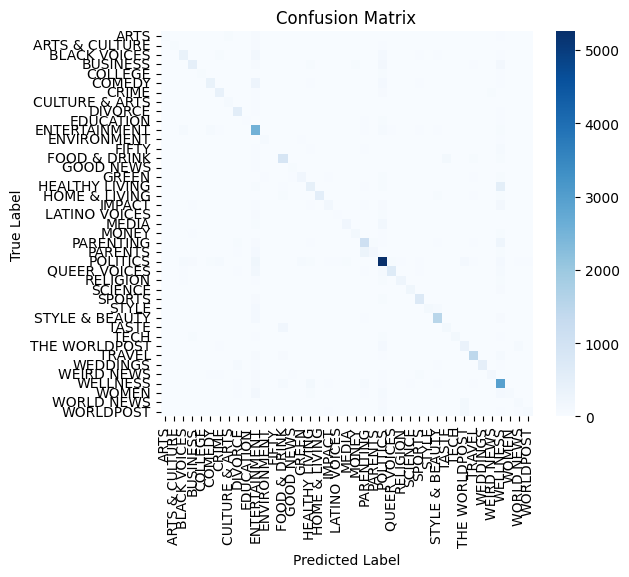


model_custom w/ a 0.4 dropout set


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.


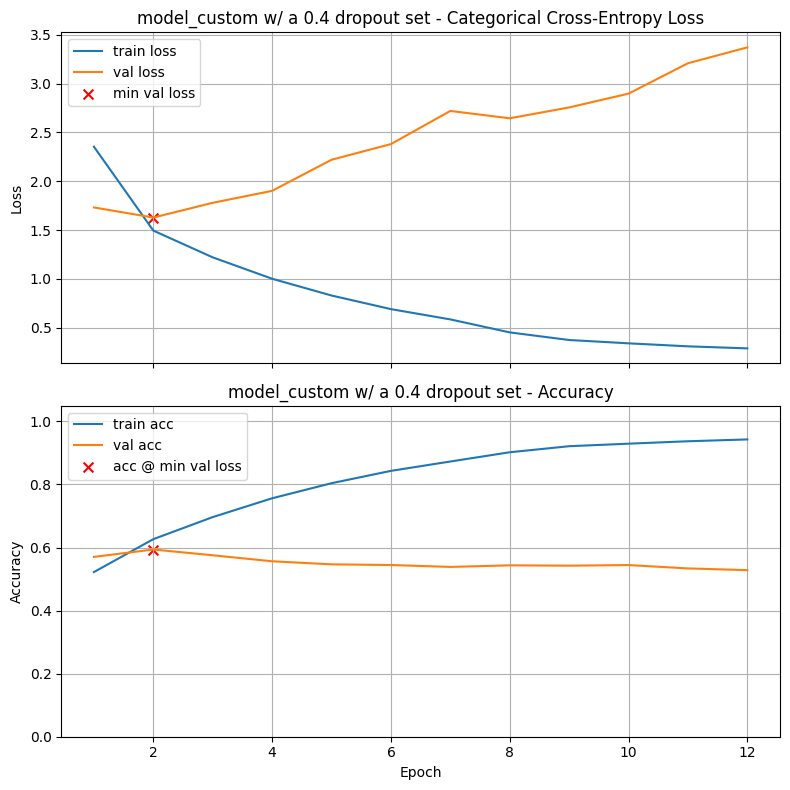


Execution Time: 00:01:24

Final Training Loss:          0.2887
Final Training Accuracy:        0.9428
Final Validation Loss:          3.3712
Final Validation Accuracy:      0.5283
Minimum Validation Loss:        1.6284 (Epoch 2)
Validation Accuracy @ Min Loss: 0.5937

Test Loss: 1.6232
Test Accuracy: 0.5944

Validation-Test Accuracy Gap: 0.000739
627/627 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Confusion Matrix:


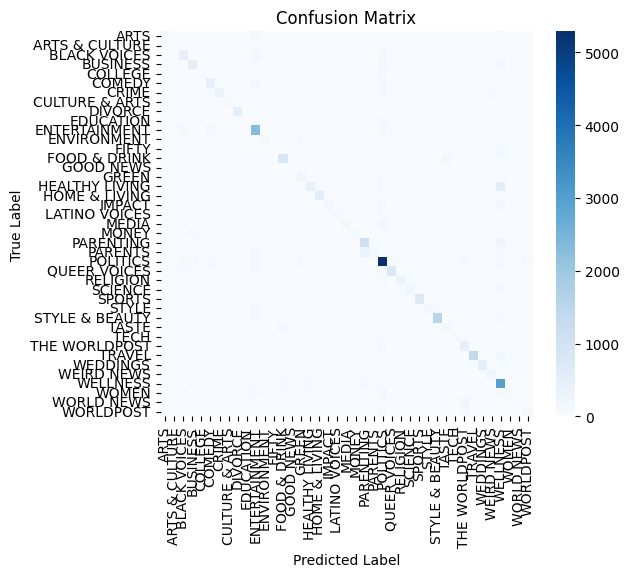


model_custom w/ a 0.5 dropout set


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.


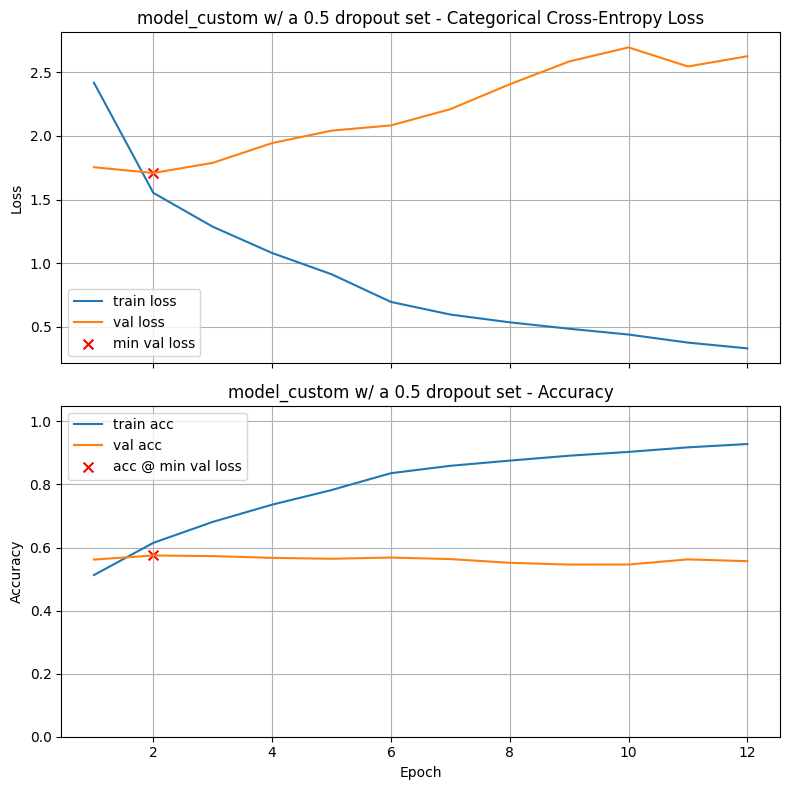


Execution Time: 00:01:22

Final Training Loss:          0.3318
Final Training Accuracy:        0.9282
Final Validation Loss:          2.6248
Final Validation Accuracy:      0.5567
Minimum Validation Loss:        1.7085 (Epoch 2)
Validation Accuracy @ Min Loss: 0.5749

Test Loss: 1.6997
Test Accuracy: 0.5786

Validation-Test Accuracy Gap: 0.003707
627/627 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Confusion Matrix:


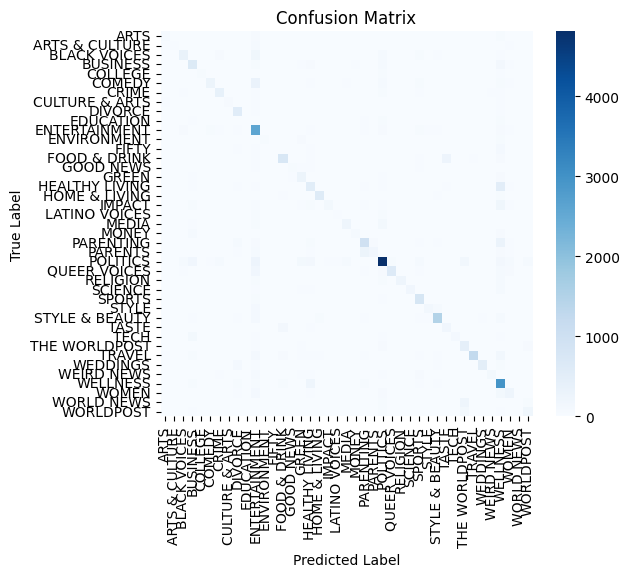

In [ ]:
# Testing dropout values
dropouts = [.1, .2, .3, .4, .5]

for i, func in enumerate(dropouts):
  model_custom = Sequential([
      Input(shape=(max_text_length,), dtype='int32'),
      Embedding(
          input_dim  = training_vocabulary_size,
          output_dim = embedding_dimension,
          weights    = [embedding_matrix],
          mask_zero  = True,
          trainable  = True
      ),
      GlobalAveragePooling1D(),
      Dense(512, activation='relu', kernel_regularizer=regularizers.l2()),
      BatchNormalization(),
      Dropout(func),
      Dense(len(label_names), activation='softmax')
  ])

  train_and_test(model_custom,
                  train_ds_tf,
                  val_ds_tf,
                  test_ds_tf,
                  lr_schedule=8e-4,
                  title=f"model_custom w/ a {func} dropout set",
                  callbacks=[reduce_lr]
                  )

## Testing Activation functions


--- Model with LeakyReLU ---


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 65, 300)        │    29,804,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       154,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 41)             │        21,033 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,981,293 (114.37 MB)

 Trainable params: 29,980,269 (114.37 MB)

 Non-trainable params: 1,024 (4.00 KB)


model_custom w/ leakyrelu


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.


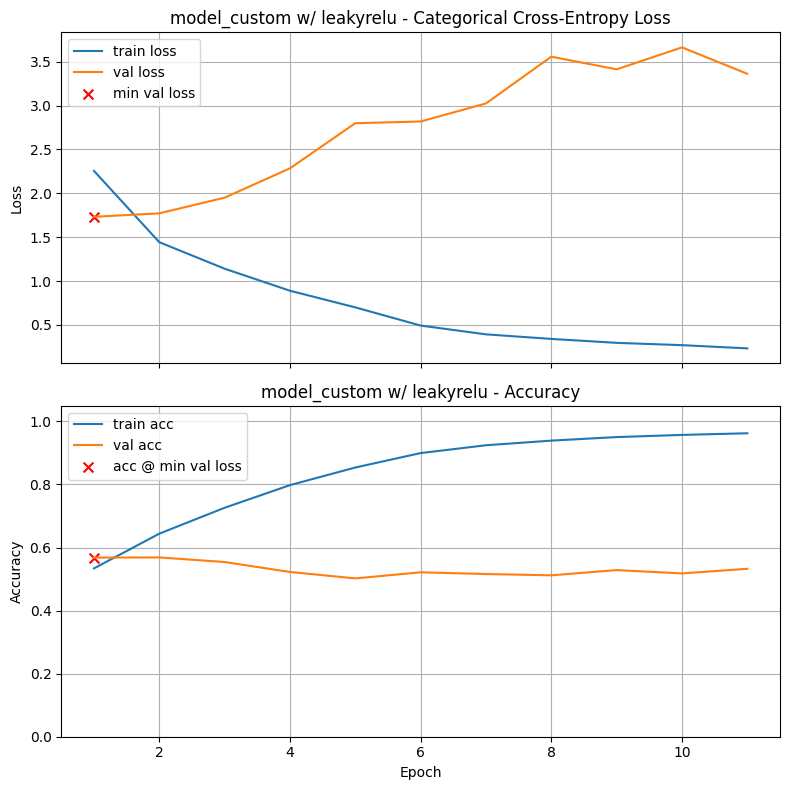


Execution Time: 00:01:17

Final Training Loss:          0.2336
Final Training Accuracy:        0.9623
Final Validation Loss:          3.3617
Final Validation Accuracy:      0.5326
Minimum Validation Loss:        1.7325 (Epoch 1)
Validation Accuracy @ Min Loss: 0.5680

Test Loss: 1.7225
Test Accuracy: 0.5688

Validation-Test Accuracy Gap: 0.000722
627/627 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Confusion Matrix:


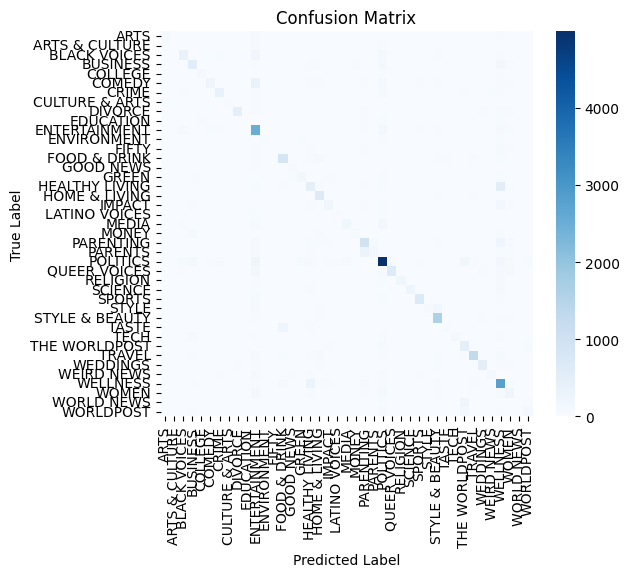

In [ ]:
from tensorflow.keras.layers import LeakyReLU # Import LeakyReLU as a layer

# Define model with LeakyReLU
model_with_leakyrelu = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    layers.Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    layers.GlobalAveragePooling1D(),
    layers.Dense(512, kernel_regularizer=regularizers.l2()),
    LeakyReLU(negative_slope=0.2), # Add LeakyReLU layer after the Dense layer
    BatchNormalization(),
    Dropout(0.2),
    layers.Dense(len(label_names), activation='softmax')
])

print("\n--- Model with LeakyReLU ---")
model_with_leakyrelu.summary()

train_and_test(model_with_leakyrelu,
                train_ds_tf,
                val_ds_tf,
                test_ds_tf,
                lr_schedule=8e-4,
                title=f"model_custom w/ leakyrelu",
                callbacks=[reduce_lr]
              )




--- Model with GELU ---


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 65, 300)        │    29,804,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       154,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 41)             │        21,033 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,981,293 (114.37 MB)

 Trainable params: 29,980,269 (114.37 MB)

 Non-trainable params: 1,024 (4.00 KB)


model_custom w/ gelu


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.


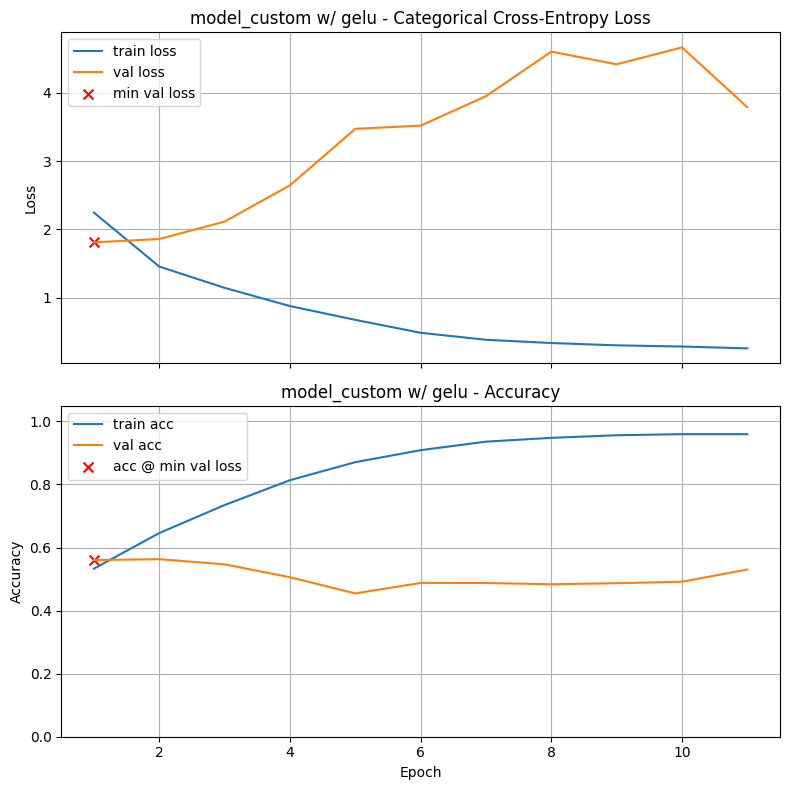


Execution Time: 00:01:16

Final Training Loss:          0.2580
Final Training Accuracy:        0.9595
Final Validation Loss:          3.7912
Final Validation Accuracy:      0.5304
Minimum Validation Loss:        1.8119 (Epoch 1)
Validation Accuracy @ Min Loss: 0.5603

Test Loss: 1.8038
Test Accuracy: 0.5585

Validation-Test Accuracy Gap: 0.001819
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Confusion Matrix:


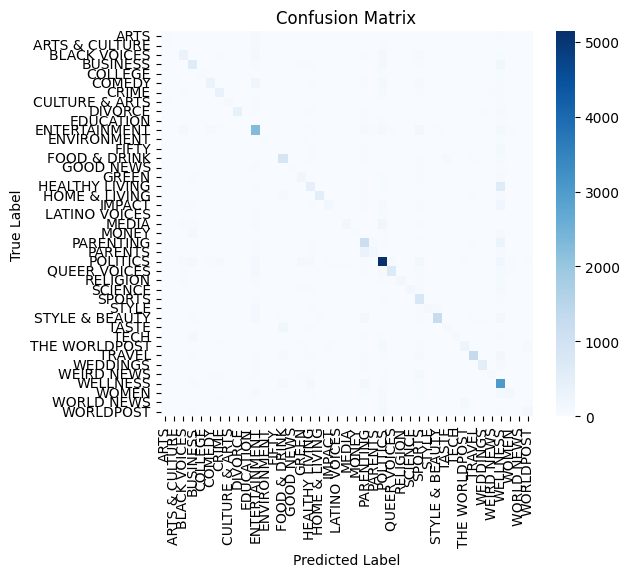

In [ ]:
# Define model with GELU
model_with_gelu = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    layers.Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    layers.GlobalAveragePooling1D(),
    layers.Dense(512, activation=tf.keras.activations.gelu, kernel_regularizer=regularizers.l2()), # GELU directly
    BatchNormalization(),
    Dropout(0.2),
    layers.Dense(len(label_names), activation='softmax')
])

print("\n--- Model with GELU ---")
model_with_gelu.summary()

train_and_test(model_with_gelu,
                train_ds_tf,
                val_ds_tf,
                test_ds_tf,
                lr_schedule=8e-4,
                title=f"model_custom w/ gelu",
                callbacks=[reduce_lr]
              )


### Graded Questions (5 pts each)

1. **Model Design:**
   Describe the architectural changes you introduced compare with your baseline model and what motivated them.

3.1. The two architectural changes implemented were batch normalization w/ dropout sets and activation function testing.  The reason these changes were chosen were to address the overfitting exhibited by the baseline model, as well as slow-convergence during validation.



2. **Training Results:**
   Present key validation and test metrics. Did your modifications improve performance?

3.2. For reference, the baseline model results are displyed below:

Baseline -> Val Acc:   .5935 <br>
            Val Loss:  1.6747 <br>
            Test Acc:  .5930 <br>
            Test Loss: 1.6727 <br>

Dropout (0.4) -> Val Acc:   .5937 <br>
                 Val Loss:  1.6284 <br>
                 Test Acc:  .5944 <br>
                 Test Loss: 1.6232 <br>

With the goal in mind to minimize the overfitting nature of the base line, the modifications did improve both test accuracy and test loss. Adding dropout and batch normalization helped baseline model improve its generalizability on the test set.




3. **Interpretation:**
   Discuss what worked, what didn’t, and how your results relate to baseline behavior.

3.3. The batch normalization saw immediate improvements to generalizability and balanced performance, both testing accuracy and test loss improved and saw the Validation-Test Accuracy Gap minimimize. Dropout sets were also trialed to combat the overfitting performance of the baseline model. Dropout percentages ranging from 10%-50% were tested and showed minor improvements for some and none for others, 40% was the sweet spot. LeakyReLU and GELU activation functions were trialed for comparative performance against the baseline ReLU activation, results showed that the baseline ReLU performed slightly better than LeakyReLU and GELU.



4. **Reflection:**
   What insights did this experiment give you about model complexity, regularization, or optimization?

3.4. Based on the experiments, the data is still too complex for the simple model enhancements made. Further improvements to the model architecture need to be made to greatly improve class prediction results. The regularization and optimization techniques can be carried over to the pretrained (transfer learning) models but experiments will also need to be run for verification.



## Problem 4 – Pretrained Model (Transfer Learning) (20 pts)

### Goal

Apply **transfer learning** to see how pretrained knowledge improves accuracy, convergence speed, and generalization.
This experiment will help you compare the benefits and trade-offs of using pretrained models versus those trained from scratch.


### Steps to Follow

1. **Select a pretrained architecture**

   * **Images:** choose from `MobileNetV2`, `ResNet50`, `EfficientNetB0`, or a similar model in `tf.keras.applications`.
   * **Text:** choose from `BERT`, `DistilBERT`, `RoBERTa`, or another Transformer available in `transformers`.

2. **Adapt the model for your dataset**

   * Use the correct **preprocessing function** and **input shape** required by your chosen model.
   * Replace the top layer with your own **classification head** (e.g., `Dense(num_classes, activation='softmax')`).

3. **Apply transfer learning**

   * Choose an appropriate **training strategy** for your pretrained model. Options include:

     * **Freezing** the pretrained base and training only a new classification head.
     * **Partially fine-tuning** selected upper layers of the base model.
     * **Full fine-tuning** (all layers trainable) with a reduced learning rate.
   * Adjust your learning rate schedule to match your strategy (e.g., smaller LR for fine-tuning).
   * Observe how your chosen approach affects **validation loss**, **training time**, and **model stability**.

4. **Train and evaluate under consistent conditions**

   * Use the same **splits**, **metrics**, and **evaluation protocol** as in earlier problems.
   * Record training duration, validation/test performance, and any resource constraints (GPU memory, runtime).

5. **Compare and analyze**

   * Observe how transfer learning changes both **performance** and **efficiency** relative to your baseline and custom models.
   * Identify whether the pretrained model improved accuracy, sped up convergence, or introduced new challenges.


In [ ]:
%pip -q install -U keras keras-hub tensorflow tensorflow-text datasets evaluate

In [ ]:
import keras
import keras_hub as kh
import evaluate

SEED        = 42
EPOCHS      = 3

keras.utils.set_random_seed(SEED)

In [ ]:
# Initialize the BertTextClassifierPreprocessor
preprocessor = kh.models.BertTextClassifierPreprocessor.from_preset(
    "bert_base_en_uncased",
    sequence_length=MAX_LENGTH
)

def map_bert_inputs(text_batch, label_batch):
    bert_inputs = preprocessor(text_batch)
    return bert_inputs, label_batch

print("Defined map_bert_inputs function.")

100%|██████████| 457/457 [00:00<00:00, 893kB/s]


Defined map_bert_inputs function.


In [ ]:
# Create TensorFlow datasets for BERT
train_ds_bert = prepare_tf_dataset("train", batch_size=64, shuffle=True, bert=True)
val_ds_bert = prepare_tf_dataset("val", batch_size=64, shuffle=False, bert=True)
test_ds_bert = prepare_tf_dataset("test", batch_size=64, shuffle=False, bert=True)

train_ds_bert_mapped = train_ds_bert.map(map_bert_inputs, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_bert_mapped = val_ds_bert.map(map_bert_inputs, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_bert_mapped = test_ds_bert.map(map_bert_inputs, num_parallel_calls=tf.data.AUTOTUNE)

print("Mapped TensorFlow datasets for BERT created:")
print(f"  Train batches: {tf.data.experimental.cardinality(train_ds_bert_mapped).numpy()}")
print(f"  Val batches: {tf.data.experimental.cardinality(val_ds_bert_mapped).numpy()}")
print(f"  Test batches: {tf.data.experimental.cardinality(test_ds_bert_mapped).numpy()}")

# Verify the format of a batch from the mapped dataset
for inputs_batch, labels_batch in train_ds_bert_mapped.take(1):
    print(f"\nMapped BERT dataset batch shapes (first batch):")
    print(f"  token_ids shape: {inputs_batch['token_ids'].shape}")
    print(f"  segment_ids shape: {inputs_batch['segment_ids'].shape}")
    print(f"  padding_mask shape: {inputs_batch['padding_mask'].shape}")
    print(f"  Labels (one-hot) shape: {labels_batch.shape}")

Mapped TensorFlow datasets for BERT created:
  Train batches: 2063
  Val batches: 443
  Test batches: 627

Mapped BERT dataset batch shapes (first batch):
  token_ids shape: (64, 65)
  segment_ids shape: (64, 65)
  padding_mask shape: (64, 65)
  Labels (one-hot) shape: (64, 41)


In [ ]:
print("Building BERT model with custom head...")

# Load the BERT encoder model (backbone) without its classification head
bert_classifier = kh.models.BertTextClassifier.from_preset(
    "bert_base_en_uncased",
    num_classes=0,
    preprocessor=preprocessor
)

# Access the underlying Keras Model which is the BERT backbone
bert_backbone = bert_classifier.backbone

# Freeze all layers of the BERT backbone
bert_backbone.trainable = True

# Define the custom classification head using the Keras Functional API
inputs = bert_backbone.input
x = bert_backbone(inputs)["pooled_output"]
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2())(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(len(label_names), activation='softmax')(x)

# Construct the full Keras model
model_bert_custom = keras.Model(inputs=inputs, outputs=outputs)

model_bert_custom.summary()

Building BERT model with custom head...


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 768),     │ 109,482,2… │ padding_mask[0][… │
│ (BertBackbone)      │ (None, None,      │            │ segment_ids[0][0… │
│                     │ 768)]             │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 512)       │    393,728 │ bert_backbone[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_16[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 41)        │     21,033 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 109,899,049 (419.23 MB)

 Trainable params: 109,898,025 (419.23 MB)

 Non-trainable params: 1,024 (4.00 KB)


model_bert_custom (trainable backbone)



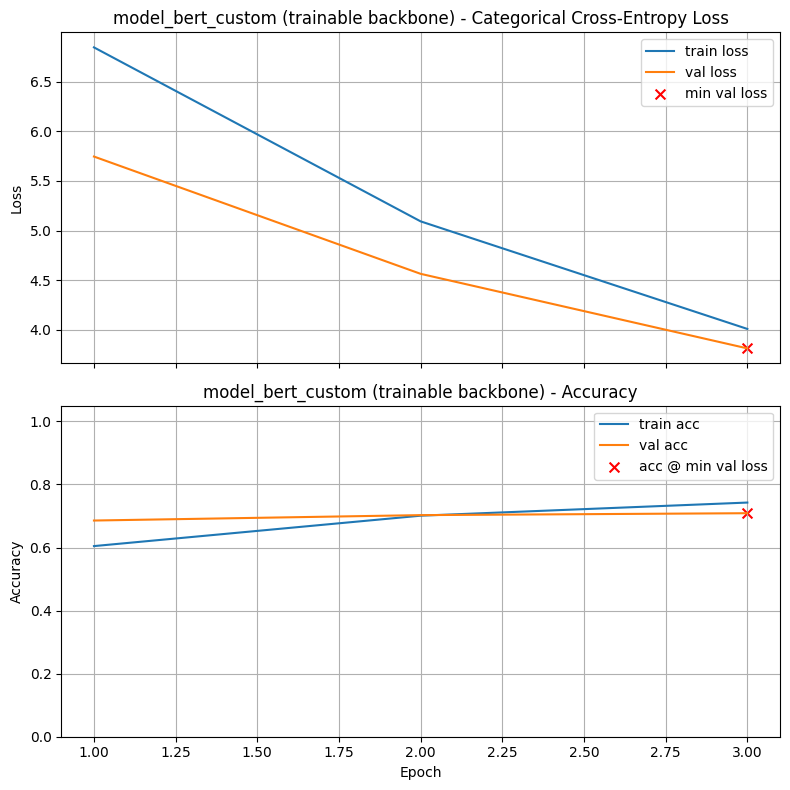


Execution Time: 00:11:35

Final Training Loss:          4.0089
Final Training Accuracy:        0.7426
Final Validation Loss:          3.8129
Final Validation Accuracy:      0.7088
Minimum Validation Loss:        3.8129 (Epoch 3)
Validation Accuracy @ Min Loss: 0.7088

Test Loss: 3.8130
Test Accuracy: 0.7090

Validation-Test Accuracy Gap: 0.000209
627/627 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step

Confusion Matrix:


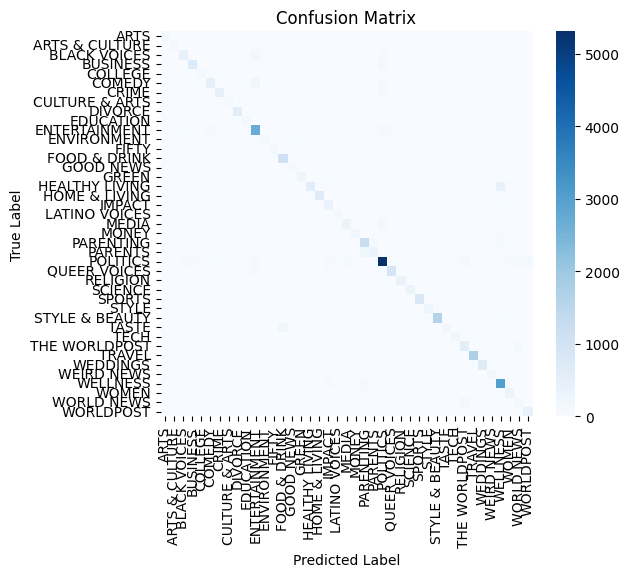

In [ ]:
train_and_test(model_bert_custom,
                train_ds_bert_mapped,
                val_ds_bert_mapped,
                test_ds_bert_mapped,
                lr_schedule=1e-5, # A smaller learning rate is often used for fine-tuning pretrained models
                title="model_bert_custom (trainable backbone)",
                callbacks=[reduce_lr],
                epochs=3 # Use a small number of epochs for initial testing with BERT
               )

### Graded Questions (5 pts each)

1. **Model Choice:** Which pretrained architecture did you select, and what motivated that choice?

4.1. Decided to use Bert-base, which is a 109M parameter pretrained model. The motivation here was familiarity since we have previously used Bert-base in a homework assignment. It was understood that it's performance over Distil-bert would be better even though the training time might be longer.



2. **Fine-Tuning Plan:** Describe your fine-tuning strategy and why you chose it.

4.2. For this pretrained model, the trainable parameter was left open to allow each node to learn and improve upon it's current variables. The learning rate was set on the smaller end at 1e-5 while the callbacks was given the learning rate reducer upon plateau. This allows for the model to search in smaller increments when it no longer finds improvement from larger jumps.



3. **Performance:** Report key metrics and compare them with your baseline and custom models.

4.3.<br>
Custom-Bert -> Val Acc: 0.7088 <br>
               Val Loss: 3.8129 <br>
               Test Acc: .7090 <br>
               Test Loss: 3.8130 <br>

Baseline -> Val Acc:   .5935 <br>
            Val Loss:  1.6747 <br>
            Test Acc:  .5930 <br>
            Test Loss: 1.6727 <br>

Dropout (0.4) -> Val Acc:   .5937 <br>
                 Val Loss:  1.6284 <br>
                 Test Acc:  .5944 <br>
                 Test Loss: 1.6232 <br>

The custom bert model was much more performative compared to the 3 other top models in this project, performing at least 10% better in both validation and testing. The loss, howeverm, didn't improve over either the custom models or the baseline.

4. **Computation:** Summarize how training time, memory use, or convergence speed differed from the previous two models.

4.4. For this project, all models were trained in Google Colab on the A100 GPU and High RAM settings.

The models from parts 2 and 3 trained much quicker, less than a minute to find there optimized values, and therefore were much easier to experiment with. It was easier to make adjustments and tune the models parameters without concern of running out of compute units in Colab. The Bert model however required additional compute units to run the model in a reasonable amount of time. The Bert model was run twice, once with a frozen backbone and once with a fully trainable backbone. The frozen backbone trained 5 minutes compared to the trainable in 12 minutes.



## Problem 5 – Comparative Evaluation and Discussion (20 pts)

### Goal

Compare your **baseline**, **custom**, and **pretrained** models to evaluate how design choices affected performance, efficiency, and generalization.
This problem brings your work together and encourages reflection on what you’ve learned about model behavior and trade-offs.

**Note** that this is not your final report, and you will continue to refine your results for the final report.

### Steps to Follow

1. **Compile key results**

   * Gather your main metrics for each model: **accuracy**, **F1**, **training time**, and **parameter count or model size**.
   * Ensure all numbers come from the same evaluation protocol and test set.

2. **Visualize the comparison**

   * Present results in a **single, well-organized chart or table**.
   * Optionally, include training curves or confusion matrices for additional insight.

3. **Analyze comparative performance**

   * Observe which model performed best by your chosen metric(s).
   * Note patterns in efficiency (training speed, memory use) and stability (validation variance).

4. **Inspect model behavior**

   * Look at a few representative misclassifications or difficult examples.
   * Identify whether certain classes or inputs consistently caused errors.

5. **Plan forward improvements**

   * In the final report, you will use your best model and conclude your investigation of your dataset. Based on your observations, decide on a model and next steps for refining your approach in the final project (e.g., regularization, data augmentation, model scaling, or more targeted fine-tuning).

In [ ]:
# Create table of the results
models = ['BERT', 'Baseline', 'Dropout (0.4)']

df_results = pd.DataFrame({
    "Models": models,
    "Validation Accuracy": [.7088, .5935, .5937],
    "Validation Loss": [3.8129, 1.6747, 1.6284],
    "Test Accuracy": [.7090, .5930, .5944],
    "Test Loss": [3.8130, 1.6727, 1.6232]
})

display(df_results)

### Graded Questions (4 pts each)

1. **Summary Table and Performance Analysis:** Present a clear quantitative comparison of all three models. Which model achieved the best overall results, and what factors contributed to its success?

5.1. From the results table, the Bert model was the most successful. Influencing factors on its performance include it's larger parameter set, more finely tweaked embeddings, and overall model complexity. Charts showcasing each models performance during training can be found above in each section.



2. **Trade-Offs:** Discuss how complexity, accuracy, and efficiency balanced across your models.

5.2.
Across the three models, we found a clear trade-off between complexity, accuracy, and efficiency. The baseline and custom models trained very quickly and were easy to experiment with, but their accuracy was limited due to the high difficulty of the dataset and the large number of classes. The BERT-based pretrained model required a lot more computation time and memory, but it produced much stronger performance and better generalization. This showed that simple models are efficient but not powerful enough for complex, real-world text classification, while larger pretrained models require more resources but provide meaningful accuracy gains.


3. **Error Patterns:** Describe the types of examples or classes that remained challenging for all models.

5.3.
All models struggled with classes that had fewer samples and with categories that had overlapping or not clear meaning. Because the dataset contains 41 labels with uneven distribution, rare classes like “EDUCATION,” “CULTURE & ARTS,” and “LATINO VOICES” were consistently harder to classify correctly. Additionally, articles with generic language, limited context, or topic overlap (for example, politics mixed with business or wellness mixed with lifestyle) often led to misclassification across all models.


4. **Next Steps:** Based on these findings, decide on a model to go forward with and outline your plan for improving that model.


5.4 Based on the results, we will move forward with the BERT-based model since it clearly achieved the best accuracy and showed the strongest potential for improvement. To enhance its performance, we would try more controlled fine-tuning by freezing lower layers, adjusting learning rates, and training for more epochs. We would also explore data-level improvements such as better text cleaning, label grouping, or techniques to handle class imbalance like focal loss or oversampling. Finally, we would consider adding regularization, experimenting with different heads, and using improved pretrained variants such as RoBERTa or DeBERTa for more gains.

### Final Question: Describe what use you made of generative AI tools in preparing this Milestone.

**AI Question:** Use of AI during this project included conversations with Gemini. The AI assisted with error handling of the bert model setup and breakdown of the input format of the model. AI was also used to assist with charts and heatmaps for model training and evaluation.